<div style="
    color: blue; /* Text color */
    background-color: #f0f0f0; /* Light grey background */
    font-family: 'Pacifico', cursive; /* Stylish font */
    font-size: 40px; /* Font size */
    font-weight: bold; /* Bold text */
    padding: 20px; /* Padding around the text */
    border: 2px solid #ccc; /* Border with a light grey color */
    border-radius: 10px; /* Rounded corners */
    text-align: center; /* Centered text */
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); /* Subtle shadow */
    position: relative; /* Required for pseudo-elements positioning */
    display: inline-block; /* Inline-block for proper spacing */
">
    <span style="
        position: absolute; /* Absolute positioning */
        left: -40px; /* Positioning arrow on the left */
        top: 50%; /* Vertically center */
        transform: translateY(-50%); /* Adjust vertical alignment */
        font-size: 30px; /* Arrow size */
        color: red; /* Arrow color */
    ">➤</span>
    NN Modeling
    <span style="
        position: absolute; /* Absolute positioning */
        right: -40px; /* Positioning arrow on the right */
        top: 50%; /* Vertically center */
        transform: translateY(-50%); /* Adjust vertical alignment */
        font-size: 30px; /* Arrow size */
        color: red; /* Arrow color */
    ">➤</span>
</div>

<link href="https://fonts.googleapis.com/css2?family=Pacifico&display=swap" rel="stylesheet">


In [2]:
pip install tensorflow



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing

2024-07-02 16:02:56.218751: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-02 16:02:56.222688: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-02 16:02:56.237744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 16:02:56.266989: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 16:02:56.267020: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 16:02:56.285874: I tensorflow/core/platform/cpu_feature_guard.cc:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
prediction_days_count = 2

def get_X_Y (exception_countries = []):
    df = pd.read_csv("../Data/Raw/new_approach/Weekly_Covid_Data.csv")

    # delete called countries:
    for iso_code in exception_countries:
        df = df[df["iso_code"] != iso_code]
    df = df.reset_index(drop=True)
    
    country_num = int(len(df["iso_code"].unique()))
    
    df.drop(["iso_code", "week_no"], axis=1, inplace=True)
    #df.drop(columns=df.columns[0:1], axis=1, inplace=True)
    pop = df.iloc[0]["population"]
    last_country = df.iloc[country_num*176 - 1]
    print(last_country)
    cnt = df["population"].value_counts()
    
    # now we want to join datas together
    features_list = []
    X_list = []
    Y_list = []
    
    for i in range(country_num):  # 234 is number of countries
        for j in range(176):  # 176 is number of weeks we have
            row_list = df.loc[i * 176 + j, :].values.flatten().tolist()
            features_list.append(row_list)
    
    for i in range((len(features_list) - prediction_days_count) + 1):
        fl = features_list[i]
        fl_len = len(features_list[i])
        this_population = features_list[i][fl_len - 1]
        for j in range(1, prediction_days_count):
            if this_population == features_list[i + j][fl_len - 1]:
                fl.extend(features_list[i + j])
            else:
                this_population = -1
                break
        if this_population != -1:
            X_list.append(fl)
            Y_list.append(features_list[(i + prediction_days_count) - 1][0])
        
    return X_list, Y_list, country_num

In [5]:
import math

def train_test_splitter(X, Y, country_num, prediction_days_count, batch_count, batch_length):
    xlen = len(X)
    xs_count_for_each_country = int(xlen / country_num)
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []
    steps = math.floor((xs_count_for_each_country - (batch_count * batch_length)) / (batch_count + 1)) 
    i = 0
    for i in range(country_num):
        j = 0
        for j in range((i * xs_count_for_each_country), (i * xs_count_for_each_country) + steps):
            X_train.append(X[j])
            Y_train.append(Y[j])
        while(j + batch_length + steps < (i+1) * xs_count_for_each_country):
            for k in range(j + prediction_days_count, j + batch_length - prediction_days_count):
                X_test.append(X[k])
                Y_test.append(Y[k])
            j += batch_length
            for k in range(j, j + steps):
                X_train.append(X[k])
                Y_train.append(Y[k])
            j += steps + 1
            while j < (i+1) * xs_count_for_each_country:
                X_train.append(X[j])
                Y_train.append(Y[j])
                j += 1
    return X_train, X_test, Y_train, Y_test

In [6]:
# getting data:
X_list, Y_list, country_num = get_X_Y(["CHN"])

new_cases                     7.500000e+01
new_deaths                    2.000000e+00
new_vaccinations              0.000000e+00
new_people_vaccinated         0.000000e+00
reproduction_rate             9.500000e-01
stringency_index              8.796000e+01
excess_mortality             -1.000000e+03
population_density            4.272900e+01
median_age                    1.960000e+01
aged_65_older                 2.822000e+00
aged_70_older                 1.882000e+00
cardiovasc_death_rate         3.078460e+02
diabetes_prevalence           1.820000e+00
female_smokers                1.600000e+00
male_smokers                  3.070000e+01
hospital_beds_per_thousand    1.700000e+00
life_expectancy               6.149000e+01
human_development_index       5.710000e-01
population                    1.632054e+07
Name: 41007, dtype: float64


In [7]:
x_df = pd.DataFrame(X_list)
min_max_scaler_X = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler_X.fit_transform(x_df)

y_df = pd.DataFrame(Y_list)
min_max_scaler_Y = preprocessing.MinMaxScaler()
y_scaled = min_max_scaler_Y.fit_transform(y_df)

X_scaled_list = x_scaled.tolist()
Y_scaled_list = y_scaled.tolist()

In [8]:
X_train, X_test, Y_train, Y_test = train_test_splitter(X_scaled_list, Y_scaled_list,
                                                       country_num=country_num,
                                                       prediction_days_count=prediction_days_count,
                                                       batch_count=3,
                                                       batch_length=10)
X_tr = np.array(X_train)
y_tr = np.array(Y_train).reshape(len(Y_train))
X_te = np.array(X_test)
y_te = np.array(Y_test).reshape(len(Y_test))

In [9]:
min_val = min_max_scaler_Y.data_min_[0]
max_val = min_max_scaler_Y.data_max_[0]

In [10]:
from tensorflow.keras import backend as K

# Define the custom loss function


# Define the custom loss function
def rescale_data_tensor(data):
    return (data * (max_val - min_val) + min_val)/10 # you can delete /10 I put it because we add 10 people
                                                     # error 
    
def loss_function(y_true, y_pred):
    y_true = rescale_data_tensor(y_true)
    y_pred = rescale_data_tensor(y_pred)
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

# First Model

In [11]:
modle_1 = keras.Sequential([
    keras.Input(shape=(X_tr.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)  # No activation function for regression
])

In [12]:
modle_1.compile(optimizer='adam',
              loss=loss_function)

In [13]:
modle_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,561 (10.00 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history1 = modle_1.fit(X_tr, y_tr, validation_split=0.25, epochs=50, batch_size=50)

Epoch 1/50


577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 28738.5000 - val_loss: 10140.4688
Epoch 2/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5472.9004 - val_loss: 8102.9448
Epoch 3/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 964us/step - loss: 4822.7446 - val_loss: 8790.7744
Epoch 4/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5074.9053 - val_loss: 8780.8516
Epoch 5/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4618.7163 - val_loss: 8335.8271
Epoch 6/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4761.9434 - val_loss: 8404.5977
Epoch 7/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - loss: 4361.3062 - val_loss: 8943.5586
Epoch 8/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step - loss: 3908.9248 - val_loss: 10522.5605
Epoch 9/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step - loss: 4272.1123 - val_loss: 8705.1123
Epoch 10/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4282.9775 - val_loss: 6936.3916
Epoch 11/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3463.0872 - val_lo

In [15]:
y_pred = modle_1.predict (X_te)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [16]:
loss_function(y_te, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=8142.604300774079>

# Second Model

In [17]:
model_2 = keras.Sequential([
    keras.Input(shape=(X_tr.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # No activation function for regression
])

In [18]:
model_2.compile(optimizer='adam',
              loss=loss_function)

In [19]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,361 (60.00 KB)

 Trainable params: 15,361 (60.00 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history2 = model_2.fit(X_tr, y_tr, validation_split=0.25, epochs=100, batch_size=32)

Epoch 1/100


902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 11343.8594 - val_loss: 6246.3340
Epoch 2/100
902/902 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2789.9365 - val_loss: 2205.9902
Epoch 3/100
902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1758.6135 - val_loss: 2448.9316
Epoch 4/100
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1476.1210 - val_loss: 1435.4004
Epoch 5/100
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1316.1356 - val_loss: 1490.5731
Epoch 6/100
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1056.2085 - val_loss: 2550.4246
Epoch 7/100
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1091.4286 - val_loss: 1756.1715
Epoch 8/100
902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1010.6131 - val_loss: 1205.0743
Epoch 9/100
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1151.2354 - val_loss: 1155.5658
Epoch 10/100
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1013.7924 - val_loss: 865.1691
Epoch 11/100
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 910.4836 - val_loss

In [21]:
y_pred = model_2.predict (X_te)
loss_function(y_te, y_pred)

 1/44 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<tf.Tensor: shape=(), dtype=float64, numpy=6480.082824926976>

# Third Model

In [22]:
X_tr_reshaped = X_tr.reshape(X_tr.shape[0], X_tr.shape[1], 1)
X_te_reshaped = X_te.reshape(X_te.shape[0], X_te.shape[1], 1)

model_3 = keras.Sequential([
    keras.Input(shape=(X_tr.shape[1], 1)),
    keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='leaky_relu'),
    keras.layers.Dense(1)  # No activation function for regression
])

In [23]:
model_3.compile(optimizer='adam',
              loss=loss_function)

In [24]:
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 36, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 18, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 16, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,945 (89.63 KB)

 Trainable params: 22,945 (89.63 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history3 = model_3.fit(X_tr_reshaped, y_tr, validation_split=0.25, epochs=50, batch_size=32)

Epoch 1/50


902/902 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 9825.3701 - val_loss: 2479.3623
Epoch 2/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2259.5601 - val_loss: 2406.0459
Epoch 3/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1385.5553 - val_loss: 3099.6116
Epoch 4/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1380.3774 - val_loss: 1904.8440
Epoch 5/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1259.9109 - val_loss: 1714.7885
Epoch 6/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 954.7996 - val_loss: 1442.9064
Epoch 7/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 963.0389 - val_loss: 1494.3315
Epoch 8/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1121.8820 - val_loss: 1121.6470
Epoch 9/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 759.9714 - val_loss: 965.5307
Epoch 10/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 856.7968 - val_loss: 1214.6746
Epoch 11/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 764.1378 - val_loss: 1020.7242
Epo

In [26]:
y_pred = model_3.predict (X_te)
loss_function(y_te, y_pred)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<tf.Tensor: shape=(), dtype=float64, numpy=6813.140005124603>

# Forth Model

In [27]:
X_tr_reshaped = X_tr.reshape(X_tr.shape[0], X_tr.shape[1], 1)
X_te_reshaped = X_te.reshape(X_te.shape[0], X_te.shape[1], 1)

model_4 = keras.Sequential([
    keras.Input(shape=(X_tr.shape[1], 1)),
    keras.layers.SimpleRNN(64, activation='relu'),
    keras.layers.Dense(1)  # No activation function for regression
])

In [28]:
model_4.compile(optimizer='adam',
              loss=loss_function)

In [29]:
model_4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history4 = model_4.fit(X_tr_reshaped, y_tr, validation_split=0.25, epochs=50, batch_size=32)

Epoch 1/50


902/902 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 6841.9424 - val_loss: 3838.2605
Epoch 2/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4634.0786 - val_loss: 4088.0034
Epoch 3/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 5381.1348 - val_loss: 6229.6523
Epoch 4/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4924.1743 - val_loss: 4170.3638
Epoch 5/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4641.6714 - val_loss: 4825.7104
Epoch 6/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4813.9097 - val_loss: 5093.7607
Epoch 7/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 5013.7700 - val_loss: 4279.6929
Epoch 8/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4664.7783 - val_loss: 3544.5796
Epoch 9/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5239.9097 - val_loss: 3801.6558
Epoch 10/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4782.8418 - val_loss: 3741.0042
Epoch 11/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4813.1929 - val_loss: 3775.37

In [31]:
y_pred = model_4.predict (X_te)
loss_function(y_te, y_pred)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


<tf.Tensor: shape=(), dtype=float64, numpy=6335.471626445169>

# Fifth Model

In [32]:
X_tr_reshaped = X_tr.reshape(X_tr.shape[0], X_tr.shape[1], 1)
X_te_reshaped = X_te.reshape(X_te.shape[0], X_te.shape[1], 1)

model_5 = keras.Sequential([
    keras.Input(shape=(X_tr.shape[1], 1)),
    keras.layers.LSTM(64, activation='relu'),
    keras.layers.Dense(1)  # No activation function for regression
])

In [33]:
model_5.compile(optimizer='adam',
              loss=loss_function)

In [34]:
model_5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history5 = model_5.fit(X_tr_reshaped, y_tr, validation_split=0.25, epochs=50, batch_size=32)

Epoch 1/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 5945.9482 - val_loss: 3519.0154
Epoch 2/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 5057.4829 - val_loss: 4424.7192
Epoch 3/50
130/902 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 4102.6992

902/902 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 4101.0972 - val_loss: 2853.2791
Epoch 4/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 3519.7500 - val_loss: 2784.9653
Epoch 5/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 2964.9148 - val_loss: 2101.4006
Epoch 6/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 2160.4790 - val_loss: 1580.2175
Epoch 7/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 1718.2921 - val_loss: 1195.7965
Epoch 8/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 1487.6078 - val_loss: 1690.1342
Epoch 9/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 1496.3860 - val_loss: 1056.5498
Epoch 10/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 1179.7396 - val_loss: 1256.9521
Epoch 11/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 1206.7578 - val_loss: 934.6108
Epoch 12/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 1108.4513 - val_loss: 1237.2085
Epoch 13/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 1170.915

In [36]:
y_pred = model_5.predict (X_te)
loss_function(tf.convert_to_tensor(y_te), y_pred)

 1/44 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


<tf.Tensor: shape=(), dtype=float64, numpy=6686.008373509186>

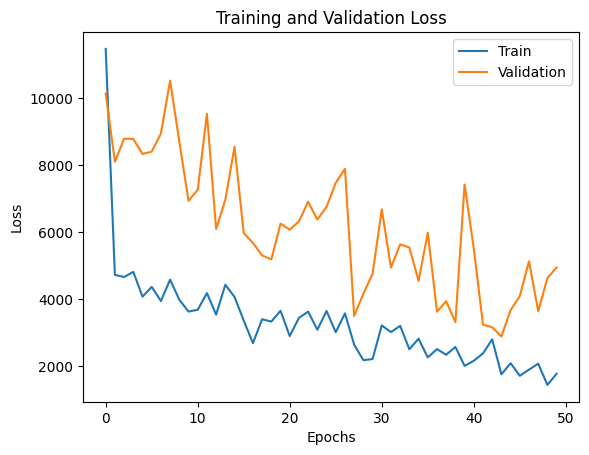

In [37]:
import matplotlib.pyplot as plt

# Assuming history1 is an object that has a history attribute with 'loss' and 'val_loss'
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Plotting the training and validation loss
plt.plot(train_loss)
plt.plot(val_loss)

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Adding a legend
plt.legend(["Train", "Validation"])

# Display the plot
plt.show()


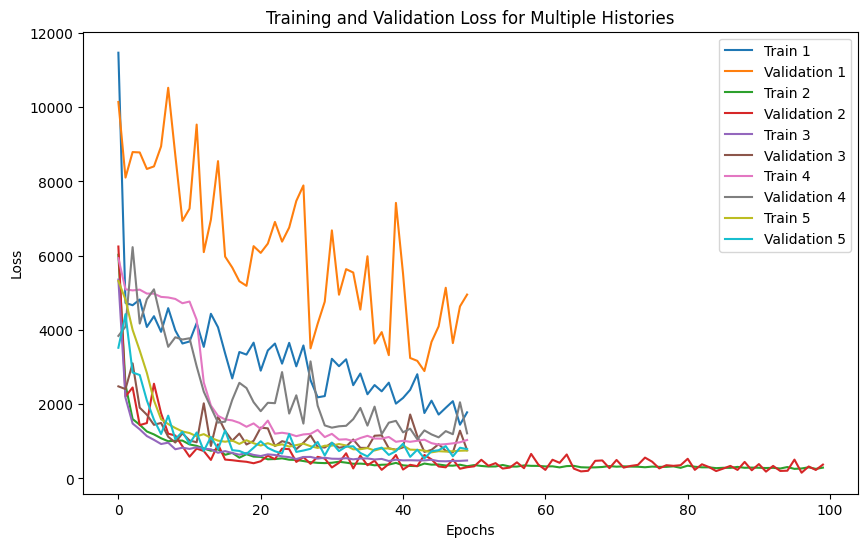

In [38]:
import matplotlib.pyplot as plt

# List of history objects
histories = [history1, history2, history3, history4, history5]

# Initialize the plot
plt.figure(figsize=(10, 6))

# Loop through each history object
for i, history in enumerate(histories):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Plotting the training and validation loss
    plt.plot(train_loss, label=f'Train {i+1}')
    plt.plot(val_loss, label=f'Validation {i+1}')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Multiple Histories')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


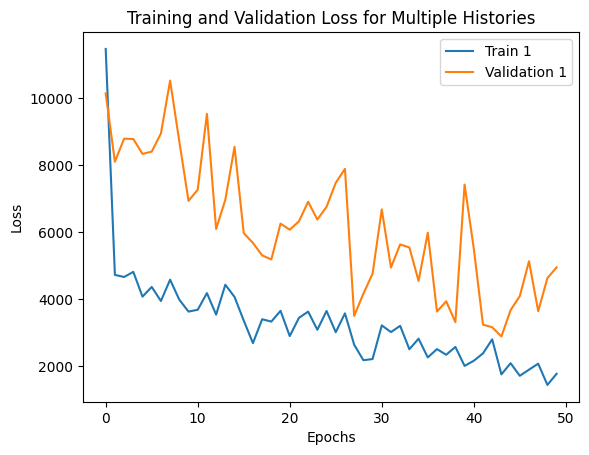

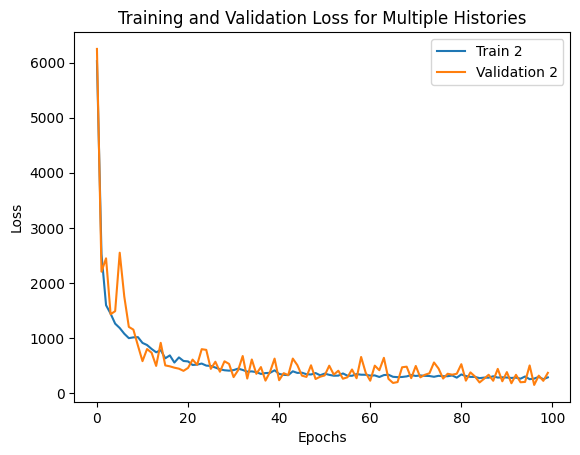

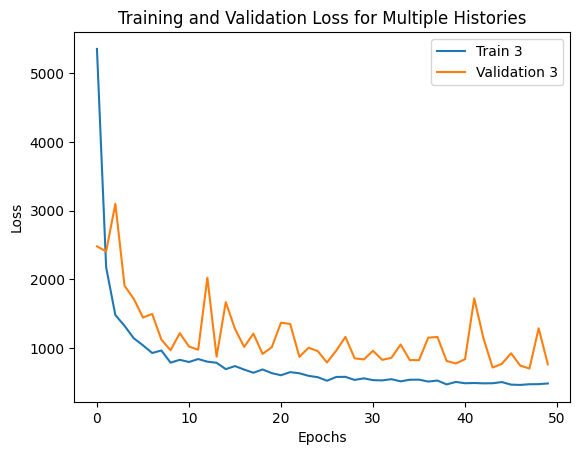

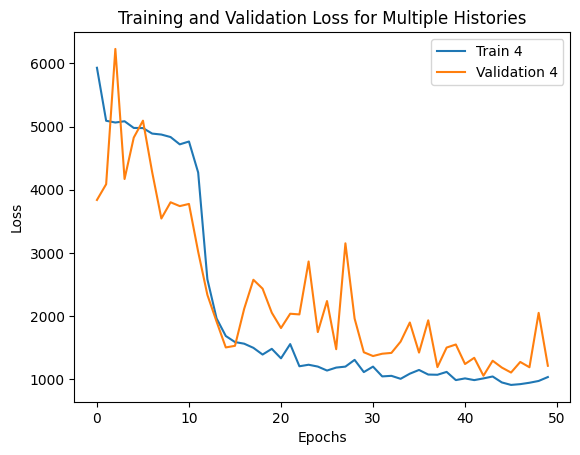

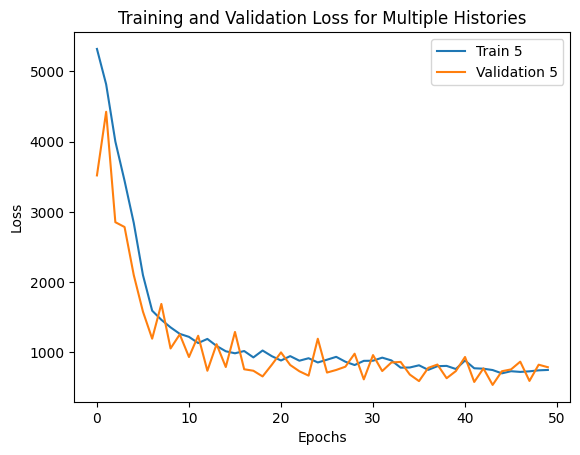

In [40]:
import matplotlib.pyplot as plt

# List of history objects
histories = [history1, history2, history3, history4, history5]

# Initialize the plot
#plt.figure(figsize=(10, 6))

# Loop through each history object
for i, history in enumerate(histories):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Plotting the training and validation loss
    plt.plot(train_loss, label=f'Train {i+1}')
    plt.plot(val_loss, label=f'Validation {i+1}')

    # Adding labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss for Multiple Histories')

    # Adding a legend
    plt.legend()

    # Display the plot
    plt.show()
